<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/eden-branch/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optional: Install HDBSCAN

In [1]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 44.5 MB/s eta 0:00:00


Importing Required Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
from hdbscan import HDBSCAN
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

Loading and Extracting Unupervised Datasets from GitHub Repository

In [2]:
import os
import zipfile

# Clone the dataset repository from GitHub
!git clone https://github.com/orifelszer/CrimeData.git

zip_folder = 'CrimeData'

# Define paths to the ZIP files
zip_files = [
    os.path.join(zip_folder, 'Clean_data_unsupervised_part1.zip'),
    os.path.join(zip_folder, 'Clean_data_unsupervised_part2.zip')
]

extracted_folders = []

# Extract ZIP files if they exist and were not previously extracted
for zip_file in zip_files:
    extract_path = zip_file.replace('.zip', '')

    if os.path.exists(zip_file):
        if not os.path.exists(extract_path):  #
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted: {zip_file} -> {extract_path}")
        else:
            print(f"Skipped: {zip_file} (Already extracted)")
    else:
        print(f"File not found: {zip_file}")

    extracted_folders.append(extract_path)


dataframes = []

# Load all CSV files from the extracted folders
for folder in extracted_folders:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.csv'):
            df_temp = pd.read_csv(file_path)
            dataframes.append(df_temp)

combined_df = pd.concat(dataframes, ignore_index=True)

# Display dataset summary
print(f"Combined dataset contains {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")

fatal: destination path 'CrimeData' already exists and is not an empty directory.
Skipped: CrimeData/Clean_data_unsupervised_part1.zip (Already extracted)
Skipped: CrimeData/Clean_data_unsupervised_part2.zip (Already extracted)
Combined dataset contains 1686927 rows and 19 columns.


K-Means Clustering: Standardization and Elbow Method for Optimal K

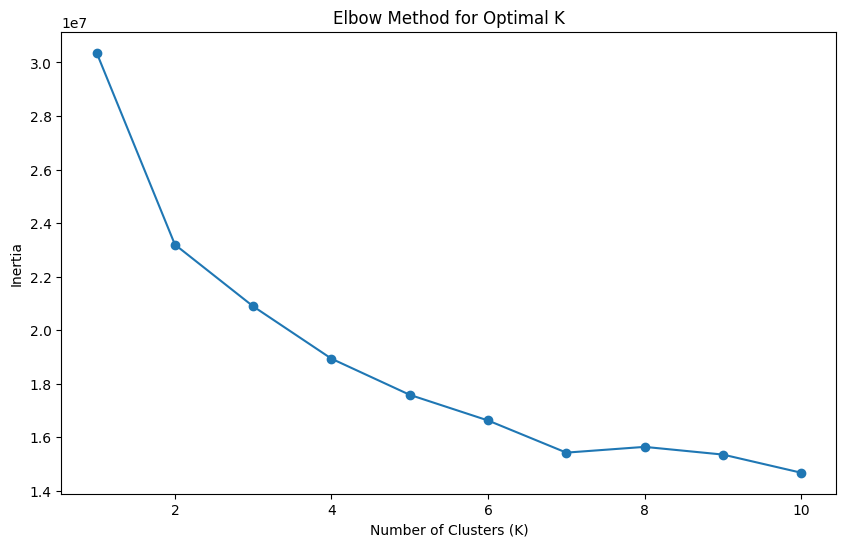

In [3]:
# Remove the identifier column before clustering
df_kmeans = combined_df.drop(columns=['FictiveIDNumber'])

# Standardize the data for K-Means clustering (important for distance-based algorithms)
scaler = StandardScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

# Determine optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

Applying K-Means Clustering and Sampling from Clusters

In [4]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_kmeans_scaled)

# Add the cluster labels back to the original (non-standardized) dataset
df_kmeans['Cluster'] = clusters

# Sample 10% of Data from Each Cluster for Analysis (Non-Standardized)
df_sample = df_kmeans.groupby('Cluster').apply(
    lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)

# Standardize the Sampled Data Using the Same Scaler
df_sample_scaled = scaler.transform(df_sample.drop(columns=['Cluster']))

<ipython-input-4-b1b358369409>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_kmeans.groupby('Cluster').apply(


Kolmogorov-Smirnov Test for Comparing Full and Sampled Datasets

In [6]:
# Define the numeric columns for the statistical test
numeric_columns = ['YeshuvCrimeRate', 'CrimeTrend', 'CrimeTrend_CrimeRate',
                   'StationCrimeRateAvg', 'YeshuvHistoricalCrimeRate', 'StationsNearbyCount']

# Perform Kolmogorov-Smirnov test for each numeric column
for column in numeric_columns:
    stat, p_value = ks_2samp(df_kmeans[column], df_sample[column])  # Two-sample KS test
    print(f"{column}: p-value = {p_value:.5f}")

    # Interpret the result based on the p-value
    if p_value > 0.05:
        print("✅ No significant difference detected!")
    else:
        print("⚠️ Significant difference detected!")

YeshuvCrimeRate: p-value = 0.65166
✅ No significant difference detected!
CrimeTrend: p-value = 0.22286
✅ No significant difference detected!
CrimeTrend_CrimeRate: p-value = 0.53963
✅ No significant difference detected!
StationCrimeRateAvg: p-value = 0.61024
✅ No significant difference detected!
YeshuvHistoricalCrimeRate: p-value = 0.65166
✅ No significant difference detected!
StationsNearbyCount: p-value = 0.81012
✅ No significant difference detected!


Comparing Categorical Distributions Between Full and Sampled Datasets

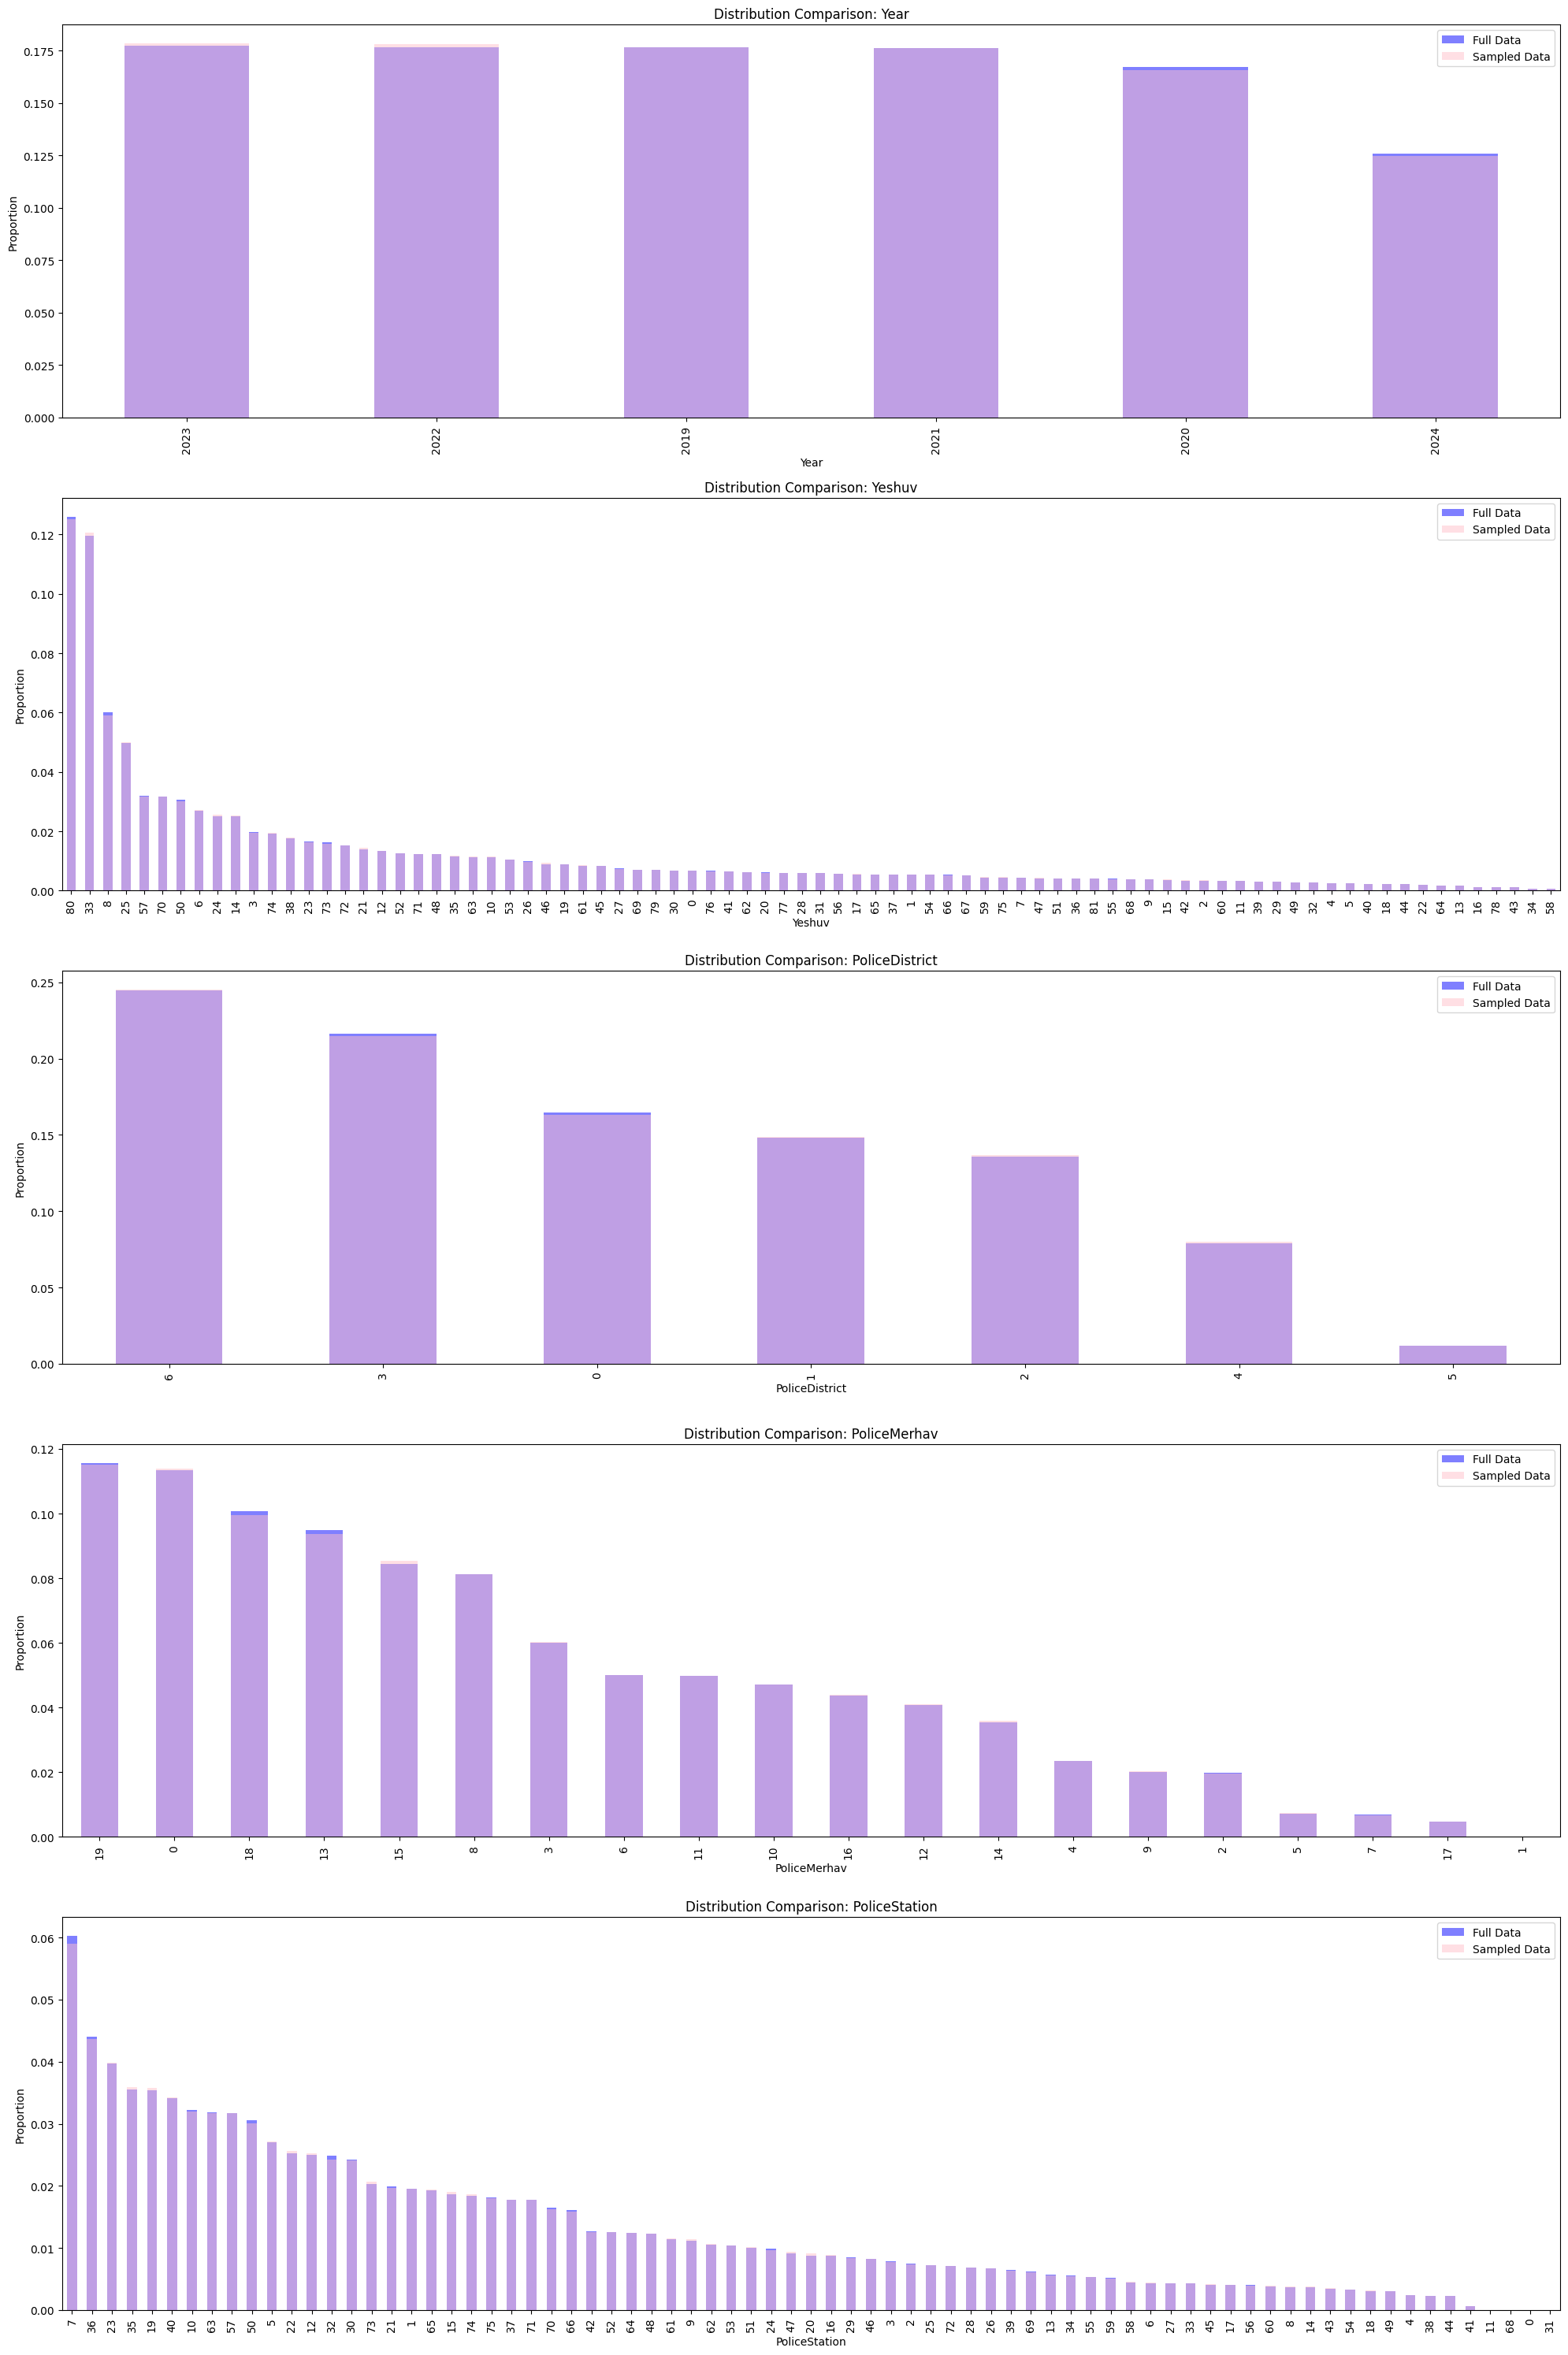

In [20]:
# Define the list of categorical columns for comparison
categorical_columns = ['Year', 'Yeshuv', 'PoliceDistrict', 'PoliceMerhav', 'PoliceStation']

# Create bar plots to compare the distribution of categorical variables
plt.figure(figsize=(20, 30))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)

    # Normalize and plot the distribution of both datasets
    df_kmeans[column].value_counts(normalize=True).plot(kind='bar', color='blue', alpha=0.5, label='Full Data')
    df_sample[column].value_counts(normalize=True).plot(kind='bar', color='pink', alpha=0.5, label='Sampled Data')

    # Set titles and labels for clarity
    plt.title(f'Distribution Comparison: {column}')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


Evaluating Optimal Number of Clusters Using Silhouette Score

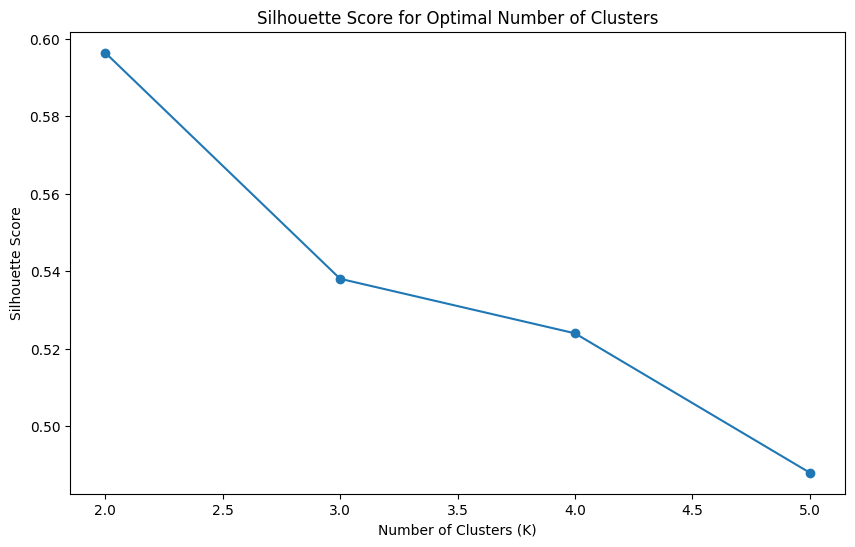

Optimal number of clusters based on Silhouette Score: 2


In [21]:
# Initialize a list to store silhouette scores for each value of K
silhouette_scores = []
k_values = range(2, 6)

# Calculate the Silhouette Score for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample)
    score = silhouette_score(df_sample, cluster_labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores for each K
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# Determine the optimal number of clusters based on the highest Silhouette Score
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")

Evaluating Optimal Number of Clusters Using Davies-Bouldin Index

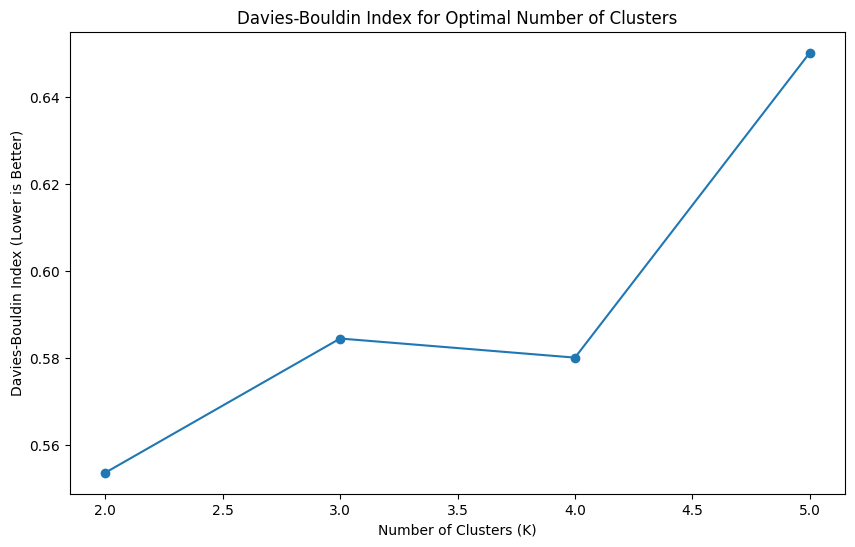

Optimal number of clusters based on Davies-Bouldin Index: 2


In [22]:
# Initialize an empty list to store Davies-Bouldin scores for each K
davies_bouldin_scores = []

# Calculate the Davies-Bouldin Index for K ranging from 2 to 6
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample)
    score = davies_bouldin_score(df_sample, cluster_labels)
    davies_bouldin_scores.append(score)

# Plot the Davies-Bouldin Index for each value of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index (Lower is Better)')
plt.show()

# Determine the optimal number of clusters based on the lowest Davies-Bouldin Index
optimal_k_db = range(2, 6)[np.argmin(davies_bouldin_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k_db}")

PCA and K-Means Clustering Visualization on the Sampled Data

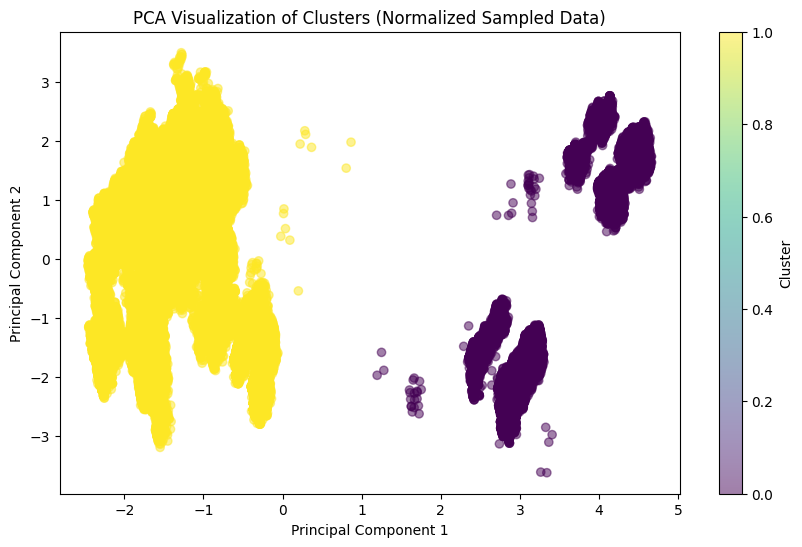

In [7]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_sample_scaled)

# Apply KMeans with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_sample_scaled)

# Visualize the PCA results with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Clusters (Normalized Sampled Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

Creating a DataFrame with Cluster Assignments and Summary Statistics

In [8]:
# Create a DataFrame with scaled features and cluster labels
df_with_clusters = pd.DataFrame(df_sample_scaled, columns=[f'Feature_{i}' for i in range(df_sample_scaled.shape[1])])
df_with_clusters['Cluster'] = clusters

# Calculate basic statistics for clusters (number of points per cluster)
unique, counts = np.unique(clusters, return_counts=True)
cluster_stats = pd.DataFrame({'Cluster': unique, 'Count': counts})

# Display cluster size statistics
display(cluster_stats)

# Calculate and display the mean values for each feature within each cluster
cluster_summary = df_with_clusters.groupby('Cluster').mean()
display(cluster_summary)

,Cluster,Count
0,0,41461
1,1,127232


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17
Cluster,,,,,,,,,,,,,,,,,,
0,-0.023695,0.570669,0.529467,-0.252115,0.584738,-0.087170,-0.086891,0.065975,0.009808,-0.016127,-0.003262,1.659093,0.014537,1.643187,1.657439,1.659093,-0.796395,0.626300
1,0.008609,-0.187807,-0.169742,0.079838,-0.190284,0.025192,0.029127,-0.018551,0.001814,-0.000555,0.000237,-0.542572,0.000931,-0.537316,-0.542058,-0.542572,0.254763,-0.200704


Applying DBSCAN Clustering and Evaluating Performance

In [9]:
# Apply DBSCAN on the scaled data
dbscan = DBSCAN(eps=3.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(df_sample)

# Count the number of clusters identified (-1 indicates noise)
unique_dbscan, counts_dbscan = np.unique(dbscan_clusters, return_counts=True)
dbscan_stats = pd.DataFrame({'Cluster': unique_dbscan, 'Count': counts_dbscan})
print(dbscan_stats)

# Calculate Silhouette Score if multiple clusters were identified
if len(unique_dbscan) > 1:
    score_dbscan = silhouette_score(df_sample, dbscan_clusters)
    print(f"Silhouette Score for DBSCAN: {score_dbscan:.2f}")
else:
    print("DBSCAN identified only one cluster. Silhouette Score not applicable.")

      Cluster  Count
0          -1  63627
1           0     13
2           1    121
3           2     14
4           3     19
...       ...    ...
3365     3364     12
3366     3365      8
3367     3366     10
3368     3367     10
3369     3368     10

[3370 rows x 2 columns]
Silhouette Score for DBSCAN: -0.01


Running KMeans with the Selected Number of Clusters (K=2)

In [10]:
# Set the optimal number of clusters
optimal_k = 2

# Initialize and fit the KMeans model on the normalized data
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_full = kmeans.fit_predict(df_kmeans_scaled)

# Add the cluster labels to the original (non-normalized) dataset
df_kmeans['Cluster'] = clusters_full

Calculating the Percentage Distribution of Clusters

In [11]:
# Display the percentage of data points in each cluster
df_kmeans['Cluster'].value_counts(normalize=True) * 100

,proportion
Cluster,
1,75.422292
0,24.577708


Visualizing Data Distribution by Clusters for Key Features

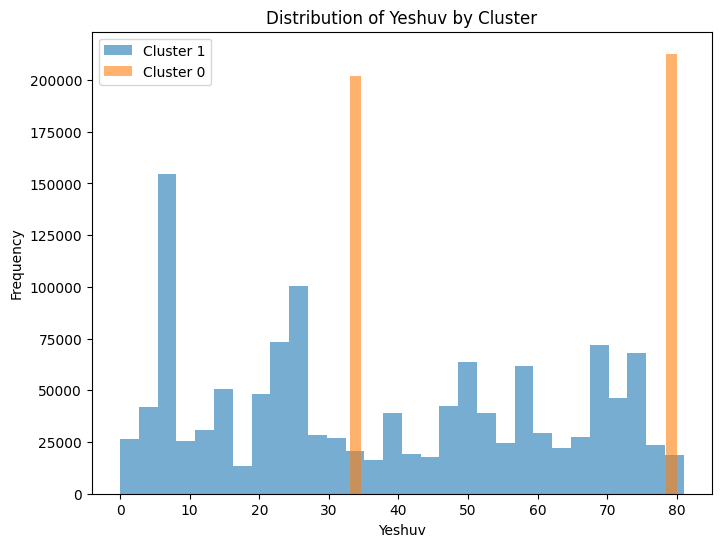

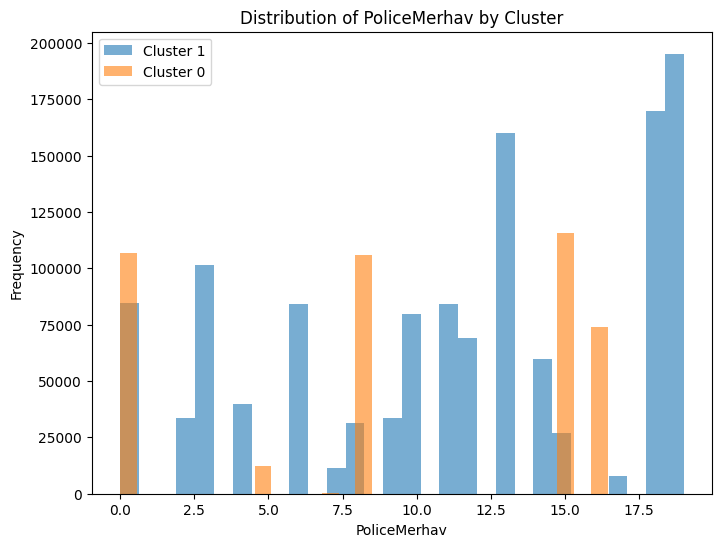

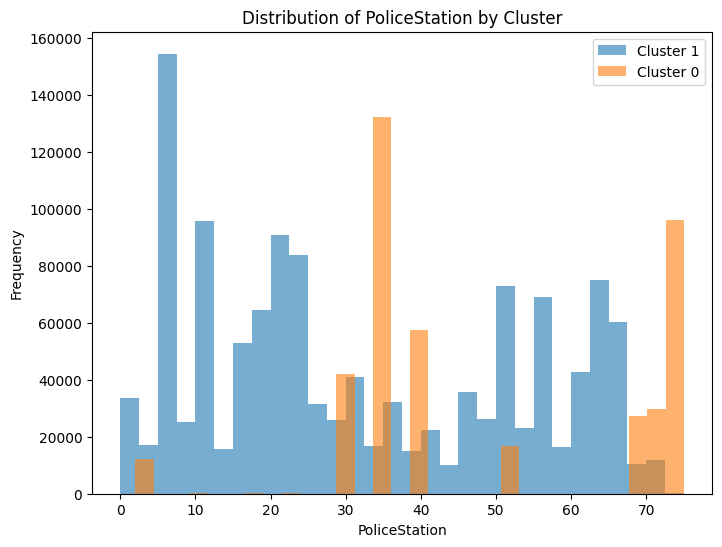

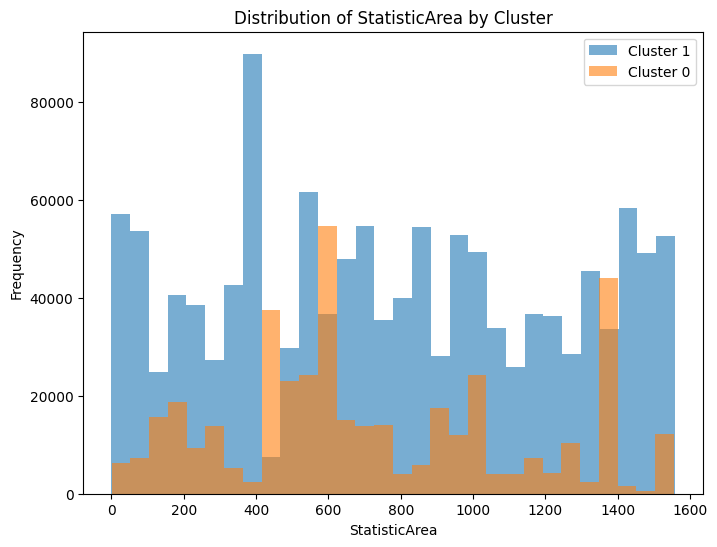

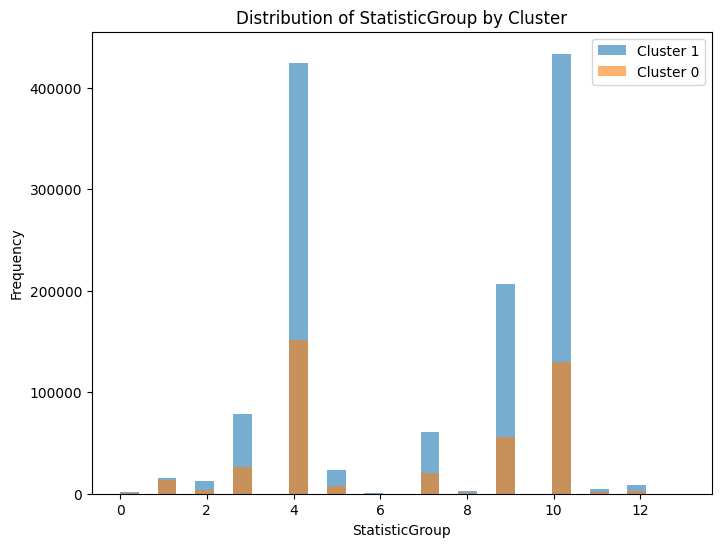

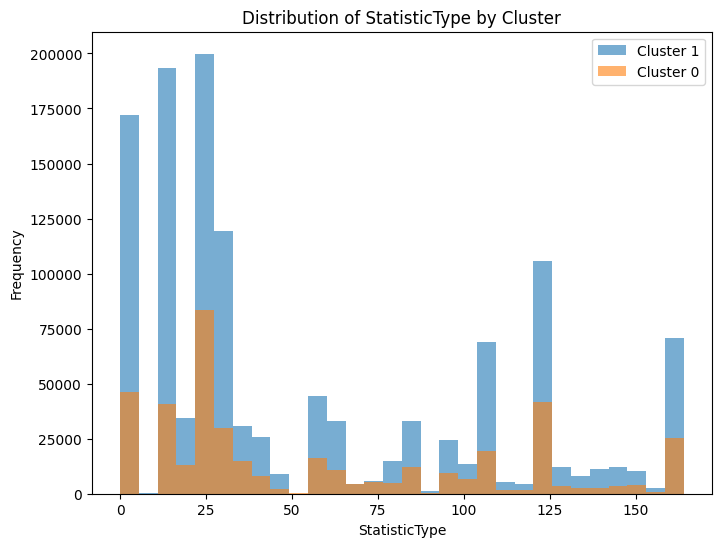

In [12]:
# Define the key features to visualize
selected_features = ['Yeshuv', 'PoliceMerhav', 'PoliceStation', 'StatisticArea', 'StatisticGroup', 'StatisticType']

# Loop through each selected feature and plot the distribution by cluster
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    for cluster in df_kmeans['Cluster'].unique():
        plt.hist(df_kmeans[df_kmeans['Cluster'] == cluster][feature],
                 alpha=0.6, label=f'Cluster {cluster}', bins=30)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Calculating Means and Standard Deviations for Key Features by Cluster

In [13]:
# Define the key features for statistical analysis
central_features = ['YeshuvCrimeRate', 'CrimeTrend', 'CrimeTrend_CrimeRate',
                    'StationCrimeRateAvg', 'YeshuvHistoricalCrimeRate', 'StationsNearbyCount']

# Calculate means and standard deviations for each cluster
cluster_means_selected = df_kmeans.groupby('Cluster')[central_features].mean()
cluster_stds_selected = df_kmeans.groupby('Cluster')[central_features].std()

# Display the results in a tabular format
print("Cluster Means (Selected Features):")
display(cluster_means_selected)

print("Cluster Standard Deviations (Selected Features):")
display(cluster_stds_selected)

Cluster Means (Selected Features):


,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount
Cluster,,,,,,
0,2.429438,4.702277,2.268856,2.475215,2.429438,2.768829
1,0.401975,4.658233,0.376978,0.406446,0.401975,3.655480


Cluster Standard Deviations (Selected Features):


,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount
Cluster,,,,,,
0,0.063104,1.771774,0.226164,0.117079,0.063104,0.751362
1,0.337668,1.821791,0.318766,0.343403,0.337668,0.757808


Performing PCA for Visualizing Clusters

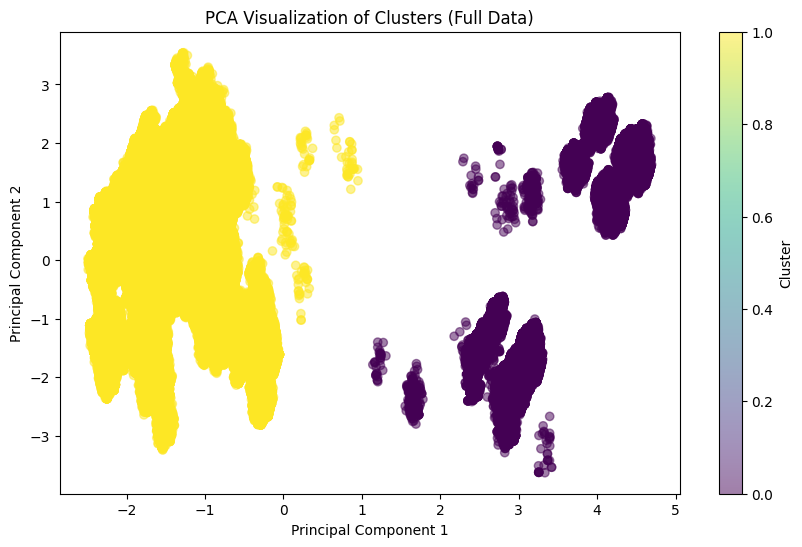

In [14]:
# Apply PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_kmeans_scaled)

# Create a scatter plot to visualize the clusters after PCA
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_kmeans['Cluster'], cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Clusters (Full Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

Comparing Clustering Algorithms: DBSCAN, HDBSCAN, and KMeans

In [ ]:
# Using the existing sample (df_sample)
#df_sample_scaled = df_sample  # No need for additional changes, sample already prepared

# Applying DBSCAN on the existing sample
dbscan = DBSCAN(eps=3.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(df_sample)

# Calculating Silhouette Score for DBSCAN (only if more than one cluster is identified)
if len(set(dbscan_clusters)) > 1:
    silhouette_dbscan = silhouette_score(df_sample, dbscan_clusters)
else:
    silhouette_dbscan = -1

# Applying HDBSCAN on the existing sample
hdbscan = HDBSCAN(min_cluster_size=50, min_samples=10)
hdbscan_clusters = hdbscan.fit_predict(df_sample)

# Calculating Silhouette Score for HDBSCAN (only if more than one cluster is identified)
if len(set(hdbscan_clusters)) > 1:
    silhouette_hdbscan = silhouette_score(df_sample, hdbscan_clusters)
else:
    silhouette_hdbscan = -1

# Displaying Comparative Results for All Clustering Algorithms
print(f"Silhouette Score for KMeans (Sampled): {max(silhouette_scores):.2f}")
print(f"Silhouette Score for DBSCAN (Sampled): {silhouette_dbscan:.2f}")
print(f"Silhouette Score for HDBSCAN (Sampled): {silhouette_hdbscan:.2f}")

print(f"Number of clusters (KMeans): {optimal_k_silhouette}")
print(f"Number of clusters (DBSCAN): {len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)}")
print(f"Number of clusters (HDBSCAN): {len(set(hdbscan_clusters)) - (1 if -1 in hdbscan_clusters else 0)}")


Pearson Correlation Between Crime Rate and Nearby Stations by Cluster

In [27]:
# Define the numeric columns for correlation analysis
numeric_columns = ['YeshuvCrimeRate', 'StationsNearbyCount']
correlation_results = {}

# Calculate Pearson correlation for each cluster
for cluster in df_kmeans['Cluster'].unique():
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster]
    corr, p_value = pearsonr(cluster_data['YeshuvCrimeRate'], cluster_data['StationsNearbyCount'])
    correlation_results[f'Cluster {cluster}'] = {'Correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for better readability
correlation_df = pd.DataFrame(correlation_results).transpose()

# Display correlation results
print("Pearson Correlation between Crime Rate and Stations Nearby Count:")
print(correlation_df)

Pearson Correlation between Crime Rate and Stations Nearby Count:
           Correlation        p_value
Cluster 1     0.019693  2.421084e-109
Cluster 0     0.998787   0.000000e+00


Boxplot Visualization for Crime Rate and Nearby Stations by Cluster

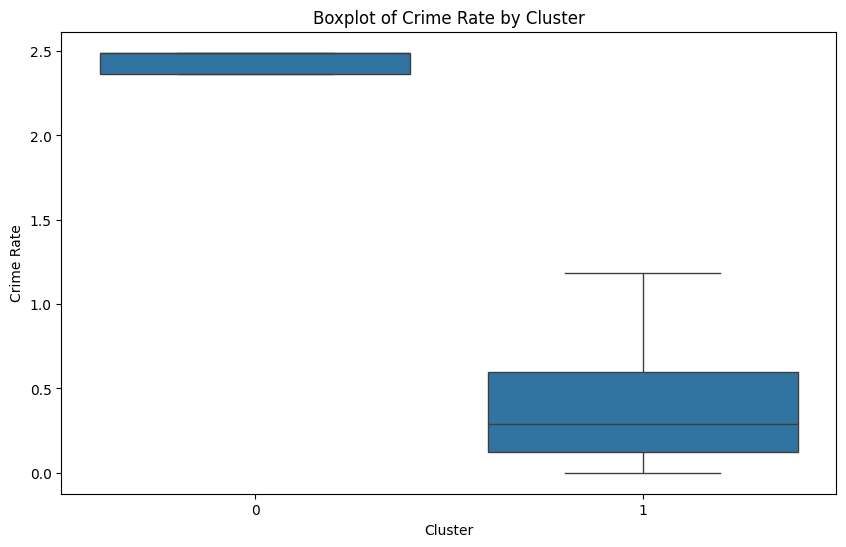

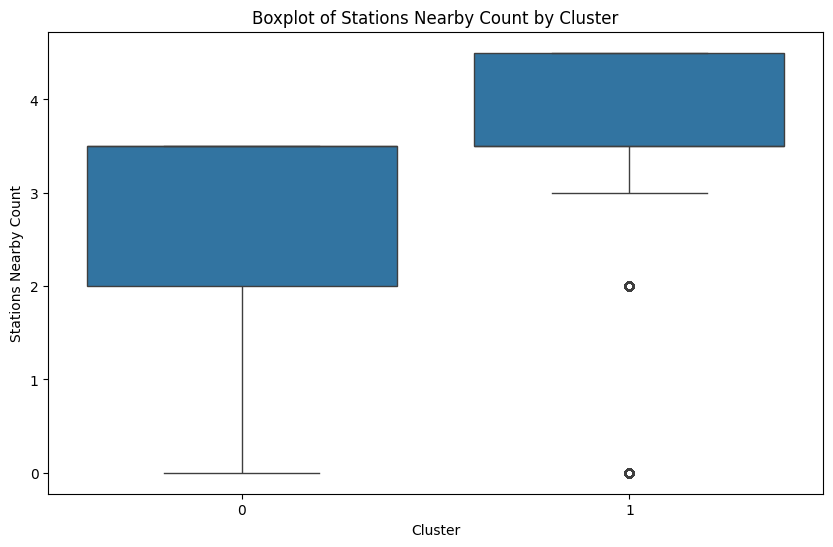

In [28]:
# Boxplot for Crime Rate across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_kmeans, x='Cluster', y='YeshuvCrimeRate')
plt.title('Boxplot of Crime Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Crime Rate')
plt.show()

# Boxplot for Nearby Stations Count across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_kmeans, x='Cluster', y='StationsNearbyCount')
plt.title('Boxplot of Stations Nearby Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Stations Nearby Count')
plt.show()